# Initial Imports


In [3]:
import numpy as np
import os
import pandas as pd
# needed to install torch like so:
#         pip3 install torch torchvision torchaudio
import torchaudio
import os

import librosa
import matplotlib.pyplot as plt
#import requests
from IPython.display import Audio, display
from google.colab import drive

from collections import Counter
from torch.utils.data import Dataset
import random
from tqdm import tqdm

# Mount Drive and Verify

In [4]:
drive.mount('/content/gdrive')

archive_path = "./gdrive/MyDrive/Accent_Recognition/archive"
recordings_path = "./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings"  

print("mounted archive_path:")
print('speakers_all.csv' in os.listdir(archive_path))
print("mounted recordings_path:")
print('hindi3.mp3' in os.listdir(recordings_path))

Mounted at /content/gdrive
mounted archive_path:
True
mounted recordings_path:
True


# Define helper functions: Mel Spectrogram, Visualization, play audio

In [5]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1, figsize=(10, 8))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

# mel spectrogram

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sample_rate = 44100

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


# Define Dataset Class

In [6]:
############
# Define a dataset class
#
# this should have methods for:
# loading
# preprocessing
# filtering
# train / test / validation splitting
###########

np.random.seed(108)

class AccentDataset(Dataset):
    def __init__(self, audio_files_folder, metadata_file, make_spectra=False):
        self.audio_files_folder = audio_files_folder
        self.metadata_file = metadata_file
        self.make_spectra = make_spectra
        self.metadata = self.load_metadata()
        self.metadata = self.filter_metadata()
        self.audio = self.load_audio()
        if not make_spectra:
            self.load_spectrograms()
        self.training_fraction = 0.67
        self.downsample_training = True
        self.downsampled_number = 5
        self.train_indices, self.test_indices = self.create_train_test_split()
        
    def load_metadata(self):
        metadata = pd.read_csv(self.metadata_file)
        return metadata
    
    def filter_metadata(self, language_samples_threshold = 30):
        self.metadata = self.metadata[self.metadata['file_missing?'] != True]
        samples_per_language = Counter(self.metadata['native_language'])    
        filtered_languages = [language for language in samples_per_language.keys() if \
                              samples_per_language[language] >= language_samples_threshold]
        filtered_speakers = self.metadata[self.metadata['native_language'].isin(filtered_languages)]
        return filtered_speakers
    
    def load_audio(self):
        audio = {}
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            audio_file = AudioFile(file_name, self.audio_files_folder, self.metadata.loc[file_index])
            if self.make_spectra:
                audio_file.make_mel_spectrogram()
            audio[file_name] = audio_file
        return audio

    def write_spectrograms(self):
        print("Writing Spectrograms to Disk")
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            spectrogram_file_full_path = os.path.join(os.path.dirname(self.audio_files_folder), 'Spectra', file_name)
            np.save(spectrogram_file_full_path, self.audio[file_name].spectrogram)

    def load_spectrograms(self):
    def create_train_test_split(self):
        unique_languages = list(set(self.metadata['native_language']))
        train_indices =[]
        test_indices = []
        for language in unique_languages:
            this_language = self.metadata[self.metadata['native_language'] == language]
            this_language_male = this_language[this_language['sex']=='male']
            this_language_female = this_language[this_language['sex']=='female']
            traininds_male = random.sample(list(this_language_male.index), 
                                           int(self.training_fraction * len(this_language_male.index)))
            traininds_female = random.sample(list(this_language_female.index), 
                                           int(self.training_fraction * len(this_language_female.index)))
            traininds = traininds_male + traininds_female
            testinds = list(set(this_language.index) - set(traininds))
            if self.downsample_training:                
                traininds = traininds_male[:self.downsampled_number] + traininds_female[:self.downsampled_number]
            train_indices += traininds
            test_indices += testinds
        return sorted(train_indices), sorted(test_indices)
    
    
class AudioFile(object):
    def __init__(self, file_name, file_path, metadata_row):
        self.file_name = file_name
        self.file_path = file_path
        self.waveform = None
        self.spectrogram = None
        self.language = metadata_row['native_language']
        self.age = metadata_row['age']
        self.sex = metadata_row['sex']
        self.metadata_row = metadata_row
    
    def __repr__(self):
        return self.file_name
        
    def load_audio_file(self):
        full_path = os.path.join(self.file_path, self.file_name + ".mp3")
        self.waveform, self.sample_rate = torchaudio.load(full_path, normalize=True)
    
    def make_mel_spectrogram(self, 
                             n_fft = 1024, 
                             win_length = None, 
                             hop_length = 512, 
                             n_mels = 128):
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
            norm="slaney",
            onesided=True,
            n_mels=n_mels,
            mel_scale="htk",
        )
        if self.waveform is None:
            self.load_audio_file()
        self.spectrogram = mel_spectrogram(self.waveform)
    
    def plot_spectrogram(self):
        if self.spectrogram is None:
            self.spectrogram = mel_spectrogram(self.waveform)
        plot_spectrogram(self.spectrogram[0,:,:200], title=self.file_name)
        plot_spectrogram(self.spectrogram[0], title=self.file_name)
    
    def play_recording(self):
        play_audio(self.waveform, self.sample_rate)
    
print("finished defining")

finished defining


# Instantiate Dataset Object

In [7]:
archive_path = "./gdrive/MyDrive/Accent_Recognition/archive"
recordings_path = "./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings"  

use_full_dataset = True
if use_full_dataset:
  speakers_file_name = "speakers_all.csv"
else:
  speakers_file_name = "speakers_half.csv"

full_dataset = AccentDataset(audio_files_folder=recordings_path, 
                             metadata_file=os.path.join(archive_path,speakers_file_name))

print("DONE")

write_spectra_to_disk = False
if write_spectra_to_disk:
  full_dataset.write_spectrograms()

100%|██████████| 1306/1306 [05:27<00:00,  3.99it/s]

DONE


# Verify Dataset Object, Display Sample Image, Play Sample Recording


In [2]:
af1 = af2 = None
af1 = full_dataset.audio['dutch10']
#af1.load_audio_file()
#af1.make_mel_spectrogram()
af1.plot_spectrogram()
af1.play_recording()


af2 = full_dataset.audio['korean44']
# af2 = AudioFile(file_name='albanian9', file_path='/Users/matt/Folders/Programming/Accent_Recognition/archive/\
# recordings/recordings')
#af2.load_audio_file()
#af2.make_mel_spectrogram()
af2.plot_spectrogram()
af2.play_recording()

NameError: ignored

# CNN-LSTM Model Preparation of Training and Testing Data

In [1]:
"""
3. Convolutional layers followed by LSTM / Recurrent layer(s)
Prepare training / testing data
"""

train_indices = full_dataset.train_indices  
test_indices = full_dataset.test_indices
number_of_train_files = len(train_indices)
number_of_test_files = len(test_indices)

metadata_train = full_dataset.metadata[full_dataset.metadata.index.isin(full_dataset.train_indices)]
metadata_test = full_dataset.metadata[full_dataset.metadata.index.isin(full_dataset.test_indices)]

file_names_training = list(metadata_train['filename'])
file_names_testing = list(metadata_test['filename'])

number_of_mels = full_dataset.audio[file_names_training[0]].spectrogram.shape[1]
spectrogram_lengths_training = [full_dataset.audio[file_name].spectrogram.shape[2] for file_name in file_names_training]
spectrogram_lengths_testing = [full_dataset.audio[file_name].spectrogram.shape[2] for file_name in file_names_testing]
spectrogram_max_length = max(max(spectrogram_lengths_training), max(spectrogram_lengths_testing))

training_languages = list(set(metadata_train['native_language']))
number_of_training_languages = len(training_languages)
training_languages_dict = dict(zip(training_languages, list(range(number_of_training_languages))))

training_genders = list(set(metadata_train['sex']))
number_of_training_genders = len(training_genders)
training_gender_dict = dict(zip(training_genders, list(range(number_of_training_genders))))
                           

NameError: ignored

# CNN-LSTM Create Torch Tensors for Training and Testing

In [1]:

# pack the training and testing spectrograms into torch tensors with zero padding:
import torch
 
def make_input_and_target(file_names, spectrogram_lengths): 
    number_of_files = len(file_names)
    input_tensor = torch.zeros(number_of_files,
                               spectrogram_max_length,
                               number_of_mels)
    target_tensor = torch.zeros(number_of_files, 
                                number_of_training_languages)
    for file_number in range(number_of_files):
        input_tensor[file_number, :spectrogram_lengths[file_number], :] = \
            full_dataset.audio[file_names[file_number]].spectrogram.T[:,:,0]
        file_language = full_dataset.audio[file_names[file_number]].language
        target_tensor[file_number, training_languages_dict[file_language]] = 1
    return input_tensor, target_tensor

 
def make_input_and_target_gender(file_names, spectrogram_lengths): 
    number_of_files = len(file_names)
    input_tensor = torch.zeros(number_of_files,
                               spectrogram_max_length,
                               number_of_mels)
    target_tensor = torch.zeros(number_of_files, 2)
    for file_number in range(number_of_files):
        input_tensor[file_number, :spectrogram_lengths[file_number], :] = \
            full_dataset.audio[file_names[file_number]].spectrogram.T[:,:,0]
        file_gender = full_dataset.audio[file_names[file_number]].sex
        target_tensor[file_number, training_gender_dict[file_gender]] = 1
    return input_tensor, target_tensor


use_gender = True
if use_gender:
    training_input, training_target = make_input_and_target_gender(file_names_training, spectrogram_lengths_training)
    testing_input, testing_target = make_input_and_target_gender(file_names_testing, spectrogram_lengths_testing)
else:
    training_input, training_target = make_input_and_target(file_names_training, spectrogram_lengths_training)
    testing_input, testing_target = make_input_and_target(file_names_testing, spectrogram_lengths_testing)
print("finished")



NameError: ignored

# CNN-LSTM Data Generator Definition

In [23]:
# define generators for inputs and labels
import random
samples_per_batch = 32
def data_generator(inputs, targets, batch_size=samples_per_batch, randomize=True):
    number_of_inputs = len(targets)  
    L=list(range(number_of_inputs))
    if randomize:
        random.shuffle(L)
    for offset in range(0, number_of_inputs, batch_size):
        batch_inputs = inputs[L[offset : offset + batch_size], :, :]
        batch_targets = targets[L[offset : offset + batch_size]]
        yield batch_inputs, batch_targets

training_generator = data_generator(training_input, training_target, batch_size=samples_per_batch)
testing_generator = data_generator(testing_input, testing_target, batch_size=samples_per_batch)

print(training_input.shape)

NameError: ignored

# CNN-LSTM Model definition

In [ ]:
"""
3. Convolutional layers followed by LSTM / Recurrent layer(s)
Construct model
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Note, torch cannot work with Intel Iris GPU on macbook pro...
Someone may make this work with OpenCL framework in the future...
"""

import torch.nn as nn
import torch.nn.functional as F
import time

cuda = torch.cuda.is_available()  
device = torch.device('cuda' if cuda else 'cpu')

print(f"using device {device}")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_dim = 464
        self.hidden_dim = 20
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bLSTM = nn.LSTM(input_size=self.layer_dim, 
                             hidden_size=self.hidden_dim, 
                             num_layers=1, 
                             bidirectional=False,
                             batch_first=True)
#         for name, param in self.bLSTM.named_parameters():
#                 if 'bias' in name:
#                      nn.init.constant_(param, 0.0)
#                 elif 'weight_ih' in name:
#                      nn.init.kaiming_normal_(param)
#                 elif 'weight_hh' in name:
#                      nn.init.orthogonal_(param)
        #self.fc2 = nn.Linear(20, number_of_training_languages)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x, hs=None):
        # Initializing hidden state for first input with zeros
        #h0 = torch.zeros(1, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        #c0 = torch.zeros(1, x.size(0), self.hidden_dim).requires_grad_()
        print("at the start of forward")
        print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         print("before transposing")
#         print(x.shape)
        x = torch.transpose(x, 1, 2)
#         print("before reshaping")
#         print(x.shape)
        x = x.reshape(x.size(0), x.size(1), -1)
        print("after reshaping")
        print(x.shape) 

    # torch.Size([32, 1437, 464])
        
#         out, (hn, cn) = self.bLSTM(x, (h0.detach(), c0.detach()))
#         out = out[:, -1, :] # we keep only the final time step
        # here, try removing all the padding at the end of the batch...
#         just_seq = torch.transpose(x, 0, 1)
#         just_seq = just_seq.reshape(just_seq.size(0), -1)
#         print("size of just_seq")
#         print(just_seq.shape)
#         seq_var = torch.var(just_seq, unbiased=False, dim=1)
#         seq_max = torch.max(just_seq, dim=1)
#         print("var shape")
#         print(seq_var.shape)
#         print(seq_var)
#         print("max:")
#         print(seq_max)
        
    
#        A, (hn, C) = self.bLSTM(x, (h0, c0))
        x, hs = self.bLSTM(x, hs)
        print(x.shape)
        #print("******")
        #print(x.shape)
        #x = x.reshape(-1, self.hidden_dim)
        x = x[:,-1,:]
        #print(x.shape)
        #print(hs[0][0].shape)
        
#         print("lstm output shapes:")
#         print(A.shape)
#         print(hn.shape)
#         print(C.shape)
#         print(hn[0].shape)
#         out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
#         print("shape of out, after lstm")
#         print(out.shape)
        #out = out[1].squeeze()
#         print("shape of x squeezed")
#         print(out.shape)
        #         print(x.shape)
#         print("shape of h_c")
#         print(h_c.shape)
#         print("shape of LSTM output")
#         print(lstm_out.shape)

        #out = F.softmax(self.fc2(out), dim=1)
    
    #    out = F.softmax(F.relu(self.fc2(hn[0])), dim=1)
        out = F.softmax(F.relu(self.fc2(x)), dim=1)
       
    #         print("shape of softmax output")
#         print(x.shape)
        return out

using device cuda


# CNN-LSTM Model Training

In [ ]:
net = Net().to(device)
net.train()
# define loss / optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
torch.autograd.set_detect_anomaly(True)


# train 
print("starting training")
epoch_loss = []
full_loss=[]
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    training_generator = data_generator(training_input, training_target, batch_size=32)
    batch_loss =[]
    for i, data in tqdm(enumerate(training_generator, 0), total=len(training_target)//32):
        inputs, labels = data
        shorten_batches = True
        if shorten_batches:
            # here try removing all the padding for this batch
#             print("in training loop, inputs shape:")
#             print(inputs.shape)
            input_tmp = torch.transpose(inputs, 0, 1)
#             print(input_tmp.shape)
            input_tmp = input_tmp.reshape(input_tmp.size(0), -1)
#             print(input_tmp.shape)
            input_tmp_var = torch.var(input_tmp, 1)
#             print(input_tmp_var.shape)
#             print(input_tmp_var)
            # find the last non-zero variance
            last_nonzero_index = np.max(np.nonzero(input_tmp_var.detach().numpy()))
#             print(last_nonzero_index)
            inputs = inputs[:,:last_nonzero_index,:]
#             print(inputs.shape)
#             print("***********")
        labels = labels.to(device)
        inputs = inputs[:,None,:,:].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
#         print("****")
#         print(outputs.shape)
#         print("----")
#         print(labels)
#         print(type(outputs[0]))
#         print(type(labels[0]))
        loss = criterion(outputs, labels)
#         print("looking at loss")
#         print(inputs.shape)
#         print(inputs[0,0,:3,:4])
#         print(outputs[0])
#         print(labels[0])
#         optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        this_loss = loss.item()
        running_loss += this_loss
        batch_loss.append(this_loss)            
#         print("at end of batch, batch loss:")
#         print(this_loss)
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    epoch_loss.append(running_loss)
    full_loss.append(batch_loss)
    running_loss = 0.0

print('Finished Training')
PATH = './gdrive/MyDrive/Accent_Recognition/torchModels/mod20gender_'+str(time.time())
torch.save(net.state_dict(), PATH)
print('Saved Model')

# CNN-LSTM Generate Inferences

In [ ]:
"""
3. Convolutional layers followed by LSTM / Recurrent layer(s)
Evaluate the inferences
"""


print("starting predictions")
net.eval()
with torch.no_grad():
    test_outputs = net(testing_input[:,None,:,:])
print("finished predicting")

starting predictions
finished predicting


# CNN-LSTM Evaluate Inferences

tensor([0.5000, 0.5000])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.]])
[]


Text(0, 0.5, 'Loss')

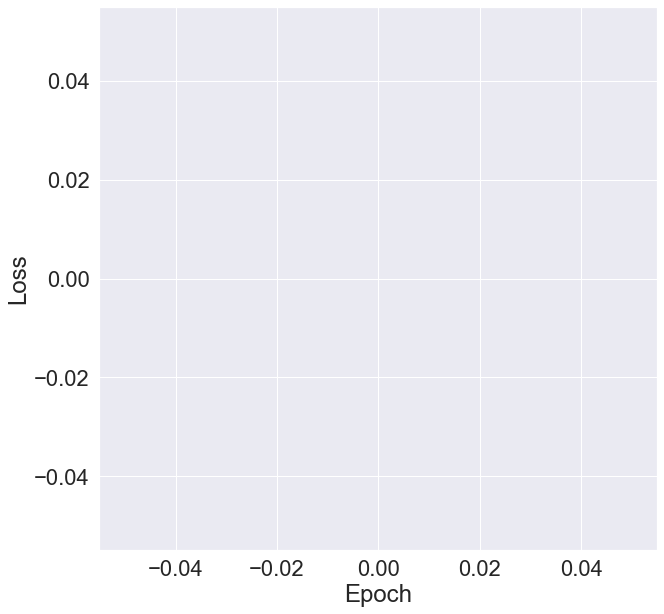

In [ ]:

print(test_outputs[0])
print(testing_target[:3])

testing_loss = criterion(test_outputs, testing_target)
# print(test_outputs.shape)
# print(test_outputs[:10])
# print(testing_target[:10])
# print(testing_loss)
#testing_target

print(full_loss)
plt.figure(figsize=(10,10))
plt.plot(full_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")


torch.Size([442, 2])


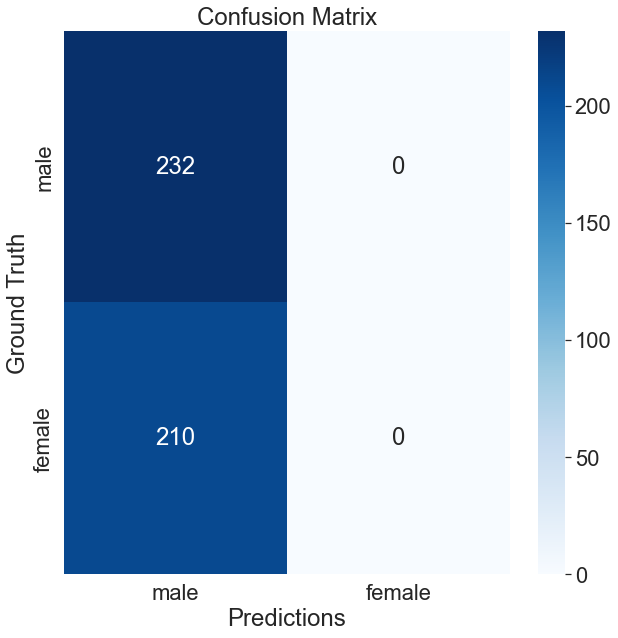

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

testing_target_np = testing_target.numpy()
# print("ok")
print(test_outputs.shape)

testing_outputs_np = test_outputs.detach().numpy()
# print(test_outputs)
# print(testing_outputs_np[0,:])
# print(np.argmax(testing_outputs_np[0,:]))

#print(np.argmax(testing_target_np,axis=1).shape)
cf_matrix = confusion_matrix(np.argmax(testing_target_np,axis=1), np.argmax(testing_outputs_np, axis=1))
plt.figure(figsize=(10,10))
if cf_matrix.shape[0] == 2:
    tick_labels = training_genders
else:
    tick_labels = training_languages
            
ax = sb.heatmap(cf_matrix, xticklabels=tick_labels, yticklabels=tick_labels, annot=True, fmt='', cmap='Blues')
#training_languages


ax.set(title="Confusion Matrix",
      xlabel="Predictions",
      ylabel="Ground Truth",)
 
sb.set(font_scale=2) # set fontsize 2

# TF CN-LSTM create TF Tensors for Training and Testing


In [ ]:
# pack the training and testing spectrograms into tensors with zero padding:
import tensorflow as tf
import numpy as np
def make_input_and_target(file_names, spectrogram_lengths): 
    number_of_files = len(file_names)
    input_tensor = np.zeros([number_of_files,
                               spectrogram_max_length,
                               number_of_mels])
    # input_tensor = torch.zeros(number_of_files,
    #                            spectrogram_max_length,
    #                            number_of_mels)
    # target_tensor = torch.zeros(number_of_files, 
    #                             number_of_training_languages)
    target_tensor = np.zeros([number_of_files, 
                                number_of_training_languages])
    for file_number in range(number_of_files):
        input_tensor[file_number, :spectrogram_lengths[file_number], :] = \
            full_dataset.audio[file_names[file_number]].spectrogram.T[:,:,0]
        file_language = full_dataset.audio[file_names[file_number]].language
        target_tensor[file_number, training_languages_dict[file_language]] = 1
    return input_tensor, target_tensor

 
def make_input_and_target_gender(file_names, spectrogram_lengths): 
    number_of_files = len(file_names)
    # input_tensor = torch.zeros(number_of_files,
    #                            spectrogram_max_length,
    #                            number_of_mels)
    # target_tensor = torch.zeros(number_of_files, 2)
    input_tensor = np.zeros([number_of_files,
                               spectrogram_max_length,
                               number_of_mels])
    target_tensor = np.zeros([number_of_files, 2])
    for file_number in range(number_of_files):
        input_tensor[file_number, :spectrogram_lengths[file_number], :] = \
            full_dataset.audio[file_names[file_number]].spectrogram.T[:,:,0]
        file_gender = full_dataset.audio[file_names[file_number]].sex
        target_tensor[file_number, training_gender_dict[file_gender]] = 1
    return input_tensor, target_tensor


use_gender = True
if use_gender:
    training_input, training_target = make_input_and_target_gender(file_names_training, spectrogram_lengths_training)
    testing_input, testing_target = make_input_and_target_gender(file_names_testing, spectrogram_lengths_testing)
else:
    training_input, training_target = make_input_and_target(file_names_training, spectrogram_lengths_training)
    testing_input, testing_target = make_input_and_target(file_names_testing, spectrogram_lengths_testing)
print("finished")

NameError: ignored

# Define Data Generator for TF


In [ ]:
train_indices = full_dataset.train_indices  
test_indices = full_dataset.test_indices
number_of_train_files = len(train_indices)
number_of_test_files = len(test_indices)

metadata_train = full_dataset.metadata[full_dataset.metadata.index.isin(full_dataset.train_indices)]
metadata_test = full_dataset.metadata[full_dataset.metadata.index.isin(full_dataset.test_indices)]

file_names_training = list(metadata_train['filename'])
file_names_testing = list(metadata_test['filename'])

number_of_mels = full_dataset.audio[file_names_training[0]].spectrogram.shape[1]
spectrogram_lengths_training = [full_dataset.audio[file_name].spectrogram.shape[2] for file_name in file_names_training]
spectrogram_lengths_testing = [full_dataset.audio[file_name].spectrogram.shape[2] for file_name in file_names_testing]
spectrogram_max_length = max(max(spectrogram_lengths_training), max(spectrogram_lengths_testing))

training_languages = list(set(metadata_train['native_language']))
number_of_training_languages = len(training_languages)
training_languages_dict = dict(zip(training_languages, list(range(number_of_training_languages))))

training_genders = list(set(metadata_train['sex']))
number_of_training_genders = len(training_genders)
training_gender_dict = dict(zip(training_genders, list(range(number_of_training_genders))))
                           


# def make_input_and_target_gender(file_names, spectrogram_lengths): 
#     number_of_files = len(file_names)
#     input_tensor = np.zeros([number_of_files,
#                                spectrogram_max_length,
#                                number_of_mels])
#     target_tensor = np.zeros([number_of_files, 2])
#     for file_number in range(number_of_files):
#         input_tensor[file_number, :spectrogram_lengths[file_number], :] = \
#             full_dataset.audio[file_names[file_number]].spectrogram.T[:,:,0]
#         file_gender = full_dataset.audio[file_names[file_number]].sex
#         target_tensor[file_number, training_gender_dict[file_gender]] = 1
#     return input_tensor, target_tensor


# training_input, training_target = make_input_and_target_gender(file_names_training, spectrogram_lengths_training)
# testing_input, testing_target = make_input_and_target_gender(file_names_testing, spectrogram_lengths_testing)



# define generators for inputs and labels
import random
samples_per_batch = 32
def data_generator_tf(dataset, 
                      target_dict, 
                      file_names,
                      spectrogram_lengths,
                      spectrogram_max_length, 
                      number_of_mels, 
                      batch_size=samples_per_batch, 
                      randomize=True):
    number_of_inputs = len(file_names)  
    L=list(range(number_of_inputs))
    if randomize:
        random.shuffle(L)
    file_number_in_batch = 0
    for offset in range(0, number_of_inputs, batch_size):
        batch_inputs = np.zeros([batch_size, spectrogram_max_length, number_of_mels])
        batch_targets = np.zeros([batch_size, len(target_dict)])
        for file_number in L[offset : offset + batch_size]:
          batch_inputs[file_number_in_batch, :spectrogram_lengths[file_number], :] = dataset.audio[file_names[file_number]].spectrogram.T[:,:,0]
          file_gender = dataset.audio[file_names[file_number]].sex
          batch_targets[file_number_in_batch, target_dict[file_gender]] = 1
          file_number_in_batch += 1
        yield batch_inputs, batch_targets

# training_generator_tf = data_generator(training_input, training_target, batch_size=samples_per_batch)
# testing_generator_tf = data_generator(testing_input, testing_target, batch_size=samples_per_batch)

training_generator_tf = data_generator_tf(dataset=full_dataset, 
                                      target_dict=training_gender_dict, 
                                      file_names=file_names_training,
                                      spectrogram_lengths=spectrogram_lengths_training,
                                      spectrogram_max_length=spectrogram_max_length, 
                                      number_of_mels=number_of_mels, 
                                      batch_size=samples_per_batch, 
                                      randomize=True)

testing_generator_tf = data_generator_tf(dataset=full_dataset, 
                                      target_dict=training_gender_dict, 
                                      file_names=file_names_testing,
                                      spectrogram_lengths=spectrogram_lengths_testing,
                                      spectrogram_max_length=spectrogram_max_length, 
                                      number_of_mels=number_of_mels, 
                                      batch_size=samples_per_batch, 
                                      randomize=True)


In [ ]:
# create data generator class
# following pattern from here: https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

class CustomDataGen(tf.keras.utils.Sequence):
    
    # def __init__(self, 
    #              df, 
    #              X_col, 
    #              y_col,
    #              batch_size,
    #              input_size=(224, 224, 3),
    #              shuffle=True):
    def __init__(self,
                dataset, 
                target_dict, 
                file_names,
                spectrogram_lengths,
                spectrogram_max_length, 
                number_of_mels, 
                batch_size=samples_per_batch, 
                randomize=True):
        self.dataset = dataset
        self.target_dict = target_dict 
        self.file_names = file_names
        self.number_of_inputs = len(self.file_names)
        self.spectrogram_lengths = spectrogram_lengths
        self.spectrogram_max_length = spectrogram_max_length 
        self.number_of_mels = number_of_mels 
        self.batch_size = batch_size      
        self.randomize = randomize    
      
        # self.df = df.copy()
        # self.X_col = X_col
        # self.y_col = y_col
        # self.batch_size = batch_size
        # self.input_size = input_size
        # self.shuffle = shuffle
        
        # self.n = len(self.df)
        # self.n_name = df[y_col['name']].nunique()
        # self.n_type = df[y_col['type']].nunique()
    
    def on_epoch_end(self):
        if self.randomize:
          L = list(range(self.number_of_inputs))
          random.shuffle(L)
          self.file_names = self.file_names[L]
          self.spectrogram_lengths = self.spectrogram_lengths[L]
        
    def __get_input(self, path, bbox, target_size):
    
        xmin, ymin, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']

        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        image_arr = image_arr[ymin:ymin+h, xmin:xmin+w]
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()

        return image_arr/255.
    
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['path']]
        bbox_batch = batches[self.X_col['bbox']]
        
        name_batch = batches[self.y_col['name']]
        type_batch = batches[self.y_col['type']]

        X_batch = np.asarray([self.__get_input(x, y, self.input_size) for x, y in zip(path_batch, bbox_batch)])

        y0_batch = np.asarray([self.__get_output(y, self.n_name) for y in name_batch])
        y1_batch = np.asarray([self.__get_output(y, self.n_type) for y in type_batch])

        return X_batch, tuple([y0_batch, y1_batch])
    
    def __getitem__(self, index):
        # The role of __getitem__ method is to generate one batch of data.
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
       #__len__ will return the number of batches the generator can produce and it will be floor(number_of_samples // batch_size)
        return self.number_of_inputs // self.batch_size



traingen = CustomDataGen(train_df,
                         X_col={'path':'filename', 'bbox': 'region_shape_attributes'},
                         y_col={'name': 'name', 'type': 'type'},
                         batch_size=batch_siz, input_size=target_size)

# training_generator_tf = data_generator_tf(dataset=full_dataset, 
#                                       target_dict=training_gender_dict, 
#                                       file_names=file_names_training,
#                                       spectrogram_lengths=spectrogram_lengths_training,
#                                       spectrogram_max_length=spectrogram_max_length, 
#                                       number_of_mels=number_of_mels, 
#                                       batch_size=samples_per_batch, 
#                                       randomize=True)


valgen = CustomDataGen(val_df,
                       X_col={'path':'filename', 'bbox': 'region_shape_attributes'},
                       y_col={'name': 'name', 'type': 'type'},
                       batch_size=batch_siz, input_size=target_size)

# model.fit(traingen,
#           validation_data=valgen,
#           epochs=num_epochs)



# TF CNN-LSTM Model Definition

In [ ]:
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
import tensorflow as tf
from keras.models import Sequential
#from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, Bidirectional, LSTM, Dropout
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Softmax  
#from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.models import Model

model = Sequential()
model.add(Conv2D(6, 
                 (5, 5), 
                 activation='relu', 
                 input_shape=(spectrogram_max_length, number_of_mels, 1)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(16, 
                 (5, 5), 
                 activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(2))
model.add(Softmax())



model.compile(optimizer='adam',
              loss='MeanSquaredError')

# TF CNN-LSTM Model Training

In [ ]:

############## # without using sequential:
# def get_model():
#     # Load the pre-trained weights of MobileNetV2 and freeze the weights
#     backbone = keras.applications.MobileNetV2(
#         weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
#     )
#     backbone.trainable = False

#     inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
#     x = keras.applications.mobilenet_v2.preprocess_input(inputs)
#     x = backbone(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.SeparableConv2D(
#         NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
#     )(x)
#     outputs = layers.SeparableConv2D(
#         NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
#     )(x)

#     return keras.Model(inputs, outputs, name="keypoint_detector")
################################################
# Model Training
################################################

# history = model.fit(trainingData,
#                     trainingLabels,
#                     batch_size=32,
#                     epochs=30,
#                     validation_data=(validationData,
#                                      validationLabels))
num_epochs = 25
model.fit(training_generator_tf,
          validation_data=testing_generator_tf,
          epochs=num_epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)


Epoch 1/25
1/1 [==============================] - 16s 16s/step - loss: 0.2913 - val_loss: 0.2504
Epoch 2/25
1/1 [==============================] - 0s 81ms/step - loss: 0.2913
